#  Predicting the Price of NVIDIA Graphics Cards based on Performance Specifications

The goal of this project is to create a model which predicts the price of NVIDIA graphics cards using the availible performance specifications.

## Data Cleaning

The raw data from the website is very messy, there is incomplete data, data with units and data with other forms of text.

In [152]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import r2_score
from scipy.stats import f_oneway, pearsonr

df = pd.read_csv('graphics_data.csv')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180 entries, 0 to 179
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Price                 180 non-null    object 
 1   GPU                   158 non-null    object 
 2   Core Clock            81 non-null     object 
 3   Boost Clock           129 non-null    object 
 4   CUDA Cores            153 non-null    float64
 5   Stream Processors     5 non-null      object 
 6   Memory Size           159 non-null    object 
 7   Memory Type           158 non-null    object 
 8   Memory Interface      159 non-null    object 
 9   Thermal Design Power  152 non-null    object 
dtypes: float64(1), object(9)
memory usage: 14.2+ KB


Most columns have some null values. The stream processors column only has 5 null values and thus should be removed.

In [153]:
df = df.drop(columns=['Stream Processors', 'Thermal Design Power'])

df

,Price,GPU,Core Clock,Boost Clock,CUDA Cores,Memory Size,Memory Type,Memory Interface
0,369.99,GeForce RTX 2060,NaN,1830 MHz,1920.0,6GB,GDDR6,192-Bit
1,399.99,GeForce RTX 2070,1620 MHz,NaN,2304.0,8GB,GDDR6,256-Bit
2,249.99,GeForce GTX 1660 SUPER,NaN,1815 MHz,1408.0,6GB,GDDR6,192-Bit
3,739.99,GeForce RTX 2080 SUPER,NaN,1815 MHz,3072.0,8GB,GDDR6,256-Bit
4,581.49,GeForce RTX 2070 SUPER,NaN,1770 MHz,2560.0,8GB,GDDR6,256-Bit
...,...,...,...,...,...,...,...,...
175,446.86,NaN,NaN,NaN,NaN,NaN,NaN,NaN
176,239.88,NaN,NaN,NaN,NaN,NaN,NaN,NaN
177,79.99,NaN,NaN,NaN,NaN,NaN,NaN,NaN
178,560.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN


There are alot of null values and columns with non numeric characters and strings. A function must be defined to extract numbers from these strings.

In [154]:
def extract_num(value):
    try:
        nums = [int(val) for val in value.split() if val.isnumeric()]
        return np.max(nums)
    except AttributeError:
        return np.nan

The target variable will be price, however it is listed as an object. This is because of commas which can be replaced with an empty string. This allows the column to be converted to a floats.

The GPU model number has been extracted from the GPU column. Whilst they are numbers, they are still just labels of GPU models, so they will be treated as categorical data.

In [155]:
df['Price'] = df['Price'].map(lambda x : float(x.replace(',','')))

df['GPU'] = df['GPU'].map(extract_num).astype(str)

For core clock and boost clock, the numbers have been extracted from the text and the maxiumum has been taken as the data for both columns is inconsistent.

In [156]:
df['Core Clock'] = df['Core Clock'].map(extract_num)
df['Boost Clock'] = df['Boost Clock'].map(extract_num)

df['Clock Speed'] = np.max(df[['Core Clock', 'Boost Clock']], axis=1)
df = df.drop(columns=['Core Clock', 'Boost Clock'])

Now null values can be removed.

The units for the remaining numerical columns must also be removed.

In [157]:
df = df.dropna()

df['Memory Size'] = df['Memory Size'].map(lambda x : int(x[:-2]))
df['Memory Interface'] = df['Memory Interface'].map(lambda x : int(x[:-4]))

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 150 entries, 0 to 179
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Price             150 non-null    float64
 1   GPU               150 non-null    object 
 2   CUDA Cores        150 non-null    float64
 3   Memory Size       150 non-null    int64  
 4   Memory Type       150 non-null    object 
 5   Memory Interface  150 non-null    int64  
 6   Clock Speed       150 non-null    float64
dtypes: float64(3), int64(2), object(2)
memory usage: 9.4+ KB


In [158]:
df

,Price,GPU,CUDA Cores,Memory Size,Memory Type,Memory Interface,Clock Speed
0,369.99,2060.0,1920.0,6,GDDR6,192,1830.0
1,399.99,2070.0,2304.0,8,GDDR6,256,1620.0
2,249.99,1660.0,1408.0,6,GDDR6,192,1815.0
3,739.99,2080.0,3072.0,8,GDDR6,256,1815.0
4,581.49,2070.0,2560.0,8,GDDR6,256,1770.0
...,...,...,...,...,...,...,...
161,559.96,2060.0,1920.0,6,GDDR6,192,1710.0
165,489.00,1060.0,1152.0,3,GDDR5,192,1506.0
166,249.99,1660.0,1536.0,6,GDDR6,192,1845.0
172,368.00,960.0,1024.0,4,GDDR5,128,1367.0


The data looks alot cleaner and is ready for analysis. There are still 150 rows and the data types are now correct.

## Analysis - numerical features

In [159]:
df.describe()

,Price,CUDA Cores,Memory Size,Memory Interface,Clock Speed
count,150.000000,150.000000,150.000000,150.000000,150.000000
mean,387.523533,1668.693333,5.786667,189.653333,1702.853333
std,268.343783,774.845436,1.926804,61.825798,194.907253
min,44.990000,192.000000,1.000000,32.000000,954.000000
25%,180.115000,928.000000,4.000000,128.000000,1680.000000
50%,307.490000,1536.000000,6.000000,192.000000,1770.000000
75%,497.242500,2176.000000,8.000000,256.000000,1830.000000
max,1250.000000,3072.000000,8.000000,384.000000,1905.000000


First the numerical features will be considered.

the following boxplot will help to identify outliers.

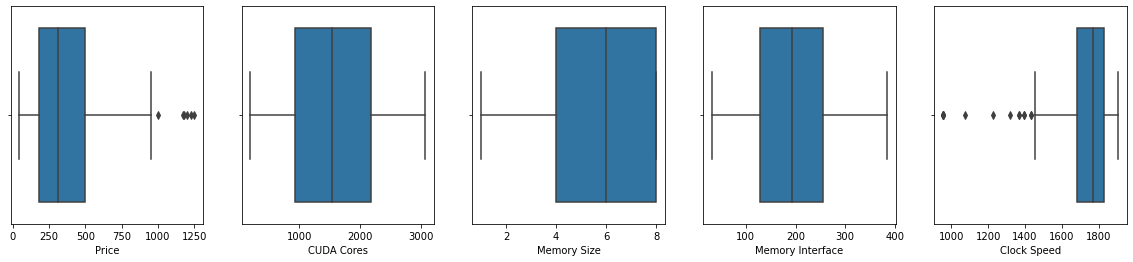

In [160]:
df_num = df.drop(columns=['GPU', 'Memory Type'])

fig, axes = plt.subplots(1, 5, figsize=(20,4))

for i, col in enumerate(df_num.columns):
    sns.boxplot(y=col, data=df, orient='h', ax=axes[i])

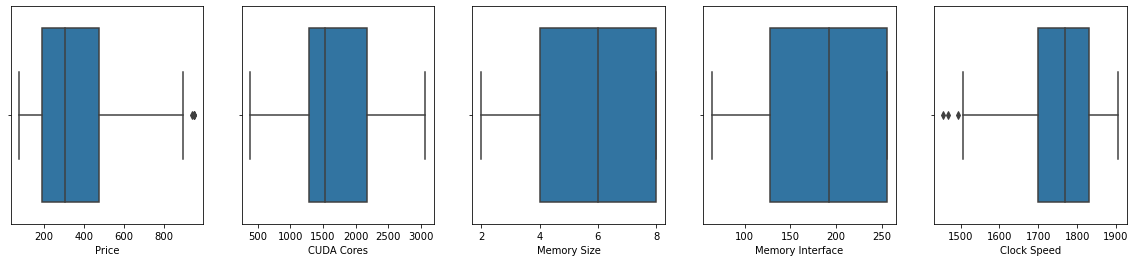

In [161]:
q1 = df.quantile(0.25)
q3 = df.quantile(0.75)
iqr = q3-q1
upper = q3 + 1.5*iqr
lower = q1 - 1.5*iqr

outliers = np.any((df < lower) | (df > upper), axis=1)
df = df.loc[~outliers]

fig, axes = plt.subplots(1, 5, figsize=(20,4))

for i, col in enumerate(df_num.columns):
    sns.boxplot(y=col, data=df, orient='h', ax=axes[i])

The outliers have been removed with the interquartile range method. 

 The heatmap below shows the correlation between the numerical variables. the values will be useful when selcting features.

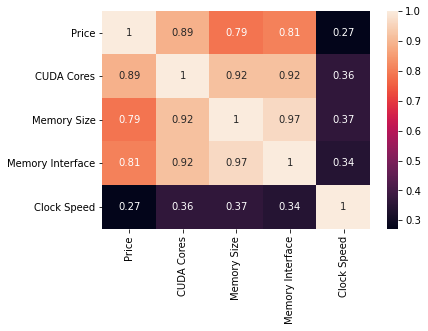

In [162]:
sns.heatmap(df.corr(), annot=True)
plt.show()

## Price

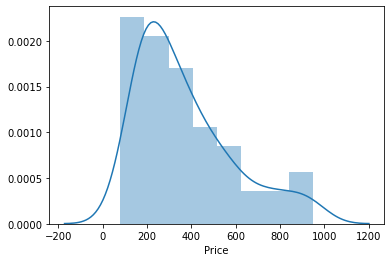

In [163]:
sns.distplot(df['Price'])
plt.show()

Price has a slightly skewed distribution to the left. The data can be simplified to consider only prices within 1 standard deviation of the mean. This may imporve accuracy of the model, since there is limited information for higher prices cards.

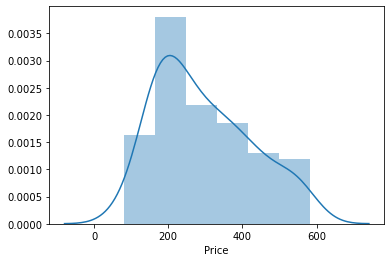

In [164]:
z_score = lambda x : (x - np.mean(x))/np.std(x)
df = df.loc[z_score(df['Price']) < 1]

sns.distplot(df['Price'])
plt.show()

The price is slighly more normally distributed and has a lower range.

## CUDA Cores

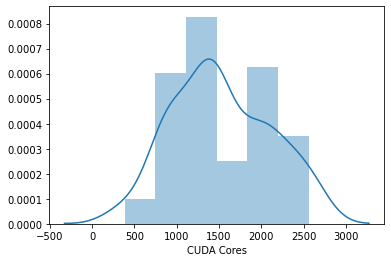

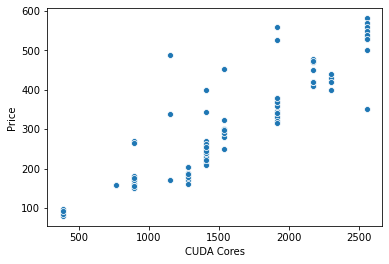

In [165]:
sns.distplot(df['CUDA Cores'])
plt.show()
sns.scatterplot(df['CUDA Cores'], df['Price'])
plt.show()

CUDA Cores has a normal distribution, with some spikes and a very clear correlation with price (0.89).

## Clock Speed

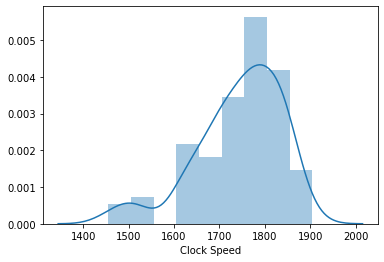

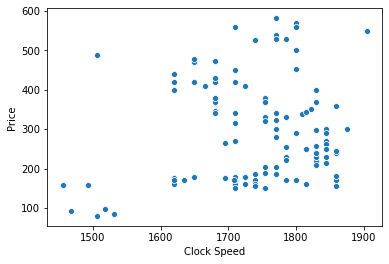

Pearson r value: 0.13233055812810746 
p value: 0.16816969950255672


In [166]:
sns.distplot(df['Clock Speed'])
plt.show()
sns.scatterplot(df['Clock Speed'], df['Price'])
plt.show()

r, p = pearsonr(df['Clock Speed'], df['Price'])
print(f'Pearson r value: {r} \np value: {p}')

The data is normally distributed witha slight skew to the right. A pearson r test gives a p value greater than 0.05, so there is not enough evidence to suggest a significant correlation between price and clock speed.

## Memory attributes

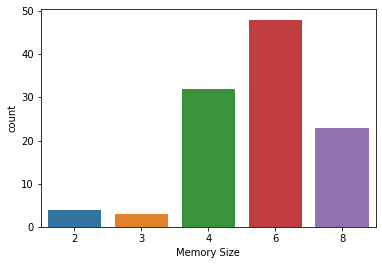

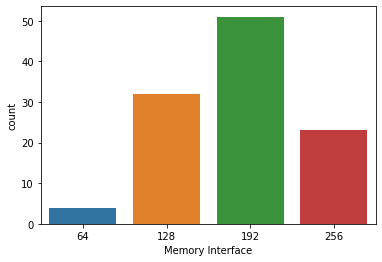

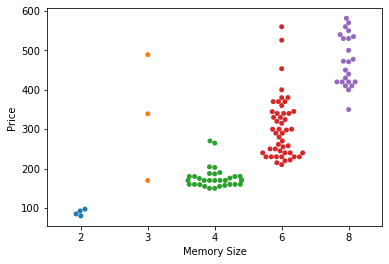

In [177]:
sns.countplot(df['Memory Size'])
plt.show()

sns.countplot(df['Memory Interface'])
plt.show()

sns.swarmplot(df['Memory Size'], df['Price'])
plt.show()

These 2 variables have a very similiar distribution and are highly correlated with each other (0.97). To reduce dimensionality, one of them can be removed. 

The swarm plot shows a very clear correlation between memory size and price.

## Analysis - categorical features

## GPU

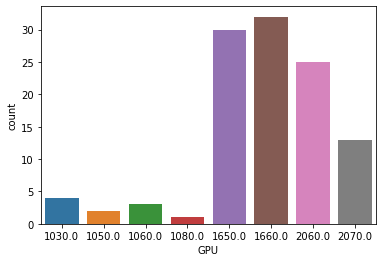

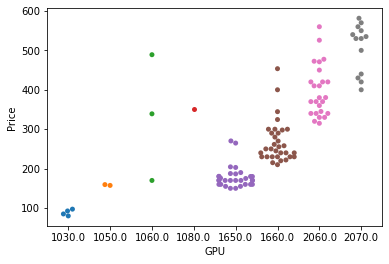

In [168]:
sns.countplot(df['GPU'])
plt.show()
sns.swarmplot(df['GPU'], df['Price'])
plt.show()

There are not many data points with cards from the 10 series (1080 or less), because they are older cards. below they are combined into 1 class.

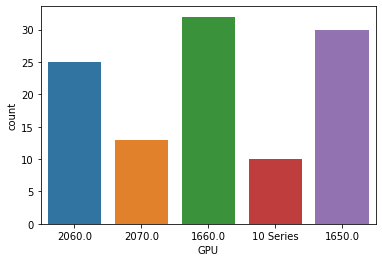

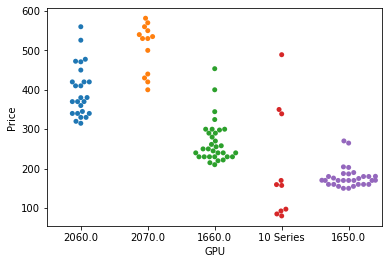

In [169]:
df['GPU'] = df['GPU'].where(df['GPU'].astype(float) > 1080, '10 Series')

sns.countplot(df['GPU'])
plt.show()
sns.swarmplot(df['GPU'], df['Price'])
plt.show()

encoder = LabelEncoder()
df['GPU'] = encoder.fit_transform(df['GPU'])

## Memory Type

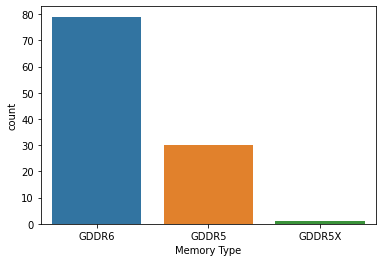

,Price,GPU,CUDA Cores,Memory Size,Memory Interface,Clock Speed
Memory Type,,,,,,
GDDR5,30,30,30,30,30,30
GDDR5X,1,1,1,1,1,1
GDDR6,79,79,79,79,79,79


In [170]:
sns.countplot(df['Memory Type'])
plt.show()

df.groupby('Memory Type').count()

There is 1 memory type class with 1 row, it appears to be a slightly better version of GDDR5. For simplicity I have relabled it GDDR5.

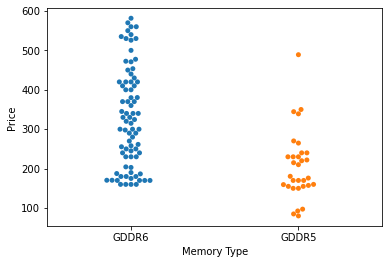

F value: 24.955667947648646 
p value: 2.2725712072646393e-06


In [171]:
df.loc[df['Memory Type'] == 'GDDR5X', 'Memory Type'] = 'GDDR5'

sns.swarmplot(df['Memory Type'], df['Price'])
plt.show()


x = df.groupby(['Memory Type'])
samp1 = df['Price'].loc[x.groups['GDDR6']]
samp2 = df['Price'].loc[x.groups['GDDR5']]

F, p = f_oneway(samp1, samp2)

print(f'F value: {F} \np value: {p}')

encoder = LabelEncoder()
df['Memory Type'] = encoder.fit_transform(df['Memory Type'])

The classes for memory type are unbalanced, but the swarm plot and the ANOVA f test performed show that the mean price of each class to differ significantly.

In [175]:
x = df.drop(columns=['Price', 'Clock Speed', 'Memory Interface'])
y = df['Price']

print(x.shape)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

model = RandomForestRegressor()
model.fit(x_train, y_train)

y_pred_test = model.predict(x_test)
y_pred_train = model.predict(x_train)

# training metrics
train_r2_value = r2_score(y_train, y_pred_train)
train_error = np.sqrt(MSE(y_train, y_pred_train))

# test metrics
test_r2_value = r2_score(y_test, y_pred_test)
test_error = np.sqrt(MSE(y_test, y_pred_test))


print(f'Training Error: {train_error} R2 score: {train_r2_value}')
print(f'Test Error: {test_error} R2 score: {test_r2_value}')

(110, 4)
Training Error: 45.554457723087914 R2 score: 0.8805604872348436
Test Error: 46.34688993307589 R2 score: 0.8258579548512845


The training error and test error are similar which suggests that there is no overfitting. The R2 scores show that the mean squared error is relatively small compared to the standard deviation of price.